# Data Smart Sans Excel

[Table of Contents](Data%20Smart%20Sans%20Excel.ipynb)

If you have not downloaded the Data Smart files then run the first code block of the main notebook and it will download the files from the web. 

## Chapter 5 - Network Graphs and Community Detection

### Using Friends Data to Create Network Graph

In [7]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [8]:
FriendsGraph = os.path.join(os.getcwd(), "data_smart_files", "ch05", "FriendsGraph.xlsx")
adjacency_matrix = pd.read_excel(FriendsGraph, 'FriendsGraph', parse_cols = "A:G", index_col=0)
adjacency_matrix

,Ross,Rachel,Chandler,Monica,Joey,Phoebe
Ross,NaN,1.0,NaN,NaN,NaN,NaN
Rachel,1.0,NaN,1.0,NaN,1.0,NaN
Chandler,NaN,1.0,NaN,1.0,NaN,1.0
Monica,NaN,NaN,1.0,NaN,NaN,NaN
Joey,NaN,1.0,NaN,NaN,NaN,NaN
Phoebe,NaN,NaN,1.0,NaN,NaN,NaN


In [109]:
def generate_edges(m):
    if not isinstance(m,pd.DataFrame):
        print ('only currently support DataFrame')
        return []
    edge_list = []
    for row in m.items():
        left = row[0]; adjacents = row[1]
        for w in adjacents[adjacents==1].items():
            right = w[0]
            if (left,right) not in edge_list and (right,left) not in edge_list:
                edge_list.append((left,right))
    return edge_list

In [110]:
G = nx.Graph()
G.add_nodes_from(adjacency_matrix.index)
G.add_edges_from(generate_edges(adjacency_matrix))
print('The graph consists of {} nodes and {} edges.'.format(G.number_of_nodes(),G.number_of_edges()))

The graph consists of 6 nodes and 5 edges.


The graphs average degree is 1.67


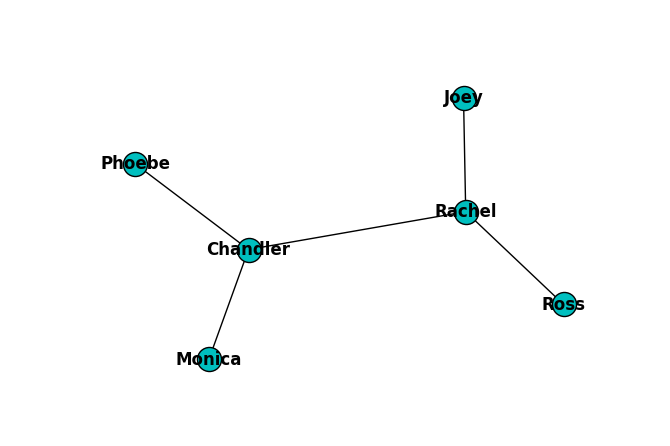

In [57]:
%matplotlib inline
nx.draw(G,with_labels=True,node_color='c',font_weight='bold')
print('The graphs average degree is {0:.2f}'.format(np.average(np.array(list(G.degree().values())))))

### Wine Data Analysis

In [58]:
WineNetwork = os.path.join(os.getcwd(), "data_smart_files", "ch05", "WineNetwork.xlsx")
wine_matrix = pd.read_excel(WineNetwork, 'Matrix', parse_cols = "A:DC", index_col=0)

#### Create Cosine Similarity Matrix
A Cosine Similarity Matrix is the count of matched purchases in the two vectors divided by the product of the square root of the number of purchases in the first vector times the square root of the number of purchases in the second vector.

In [63]:
wine_matrix_simple = wine_matrix.copy()
for c in ('Campaign','Varietal','Minimum Qty (kg)','Discount (%)','Origin','Past Peak'):
    del wine_matrix_simple[c]
customer_count = len(wine_matrix_simple.columns)
cos_sim_matrix = np.zeros((customer_count,customer_count))

In [71]:
for i,customer1 in enumerate(wine_matrix_simple.columns):
    for j,customer2 in enumerate(wine_matrix_simple.columns):
        cust1 = wine_matrix_simple[customer1]
        cust2 = wine_matrix_simple[customer2]
        if customer1 == customer2:
            cos_sim_matrix[i,j] = 0
            continue
        cos_sim_matrix[i,j] = (cust1 * cust2).sum() / (np.sqrt(cust1.sum()) * np.sqrt(cust2.sum()))
cos_sim_matrix_df = pd.DataFrame(cos_sim_matrix,
                                 index=wine_matrix_simple.columns,
                                 columns=wine_matrix_simple.columns)
cos_sim_matrix_df.head(5)

,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
Adams,0.000000,0.0,0.0,0.408248,0.000000,0.0,0.000000,0.408248,0.0,0.666667,...,0.000000,0.816497,0.0,0.408248,0.288675,0.333333,0.408248,0.0,0.000000,0.000000
Allen,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.353553,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.353553,0.288675
Anderson,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.707107,0.000000,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
Bailey,0.408248,0.0,0.0,0.000000,0.353553,0.0,0.000000,0.000000,0.0,0.816497,...,0.000000,0.000000,0.0,0.500000,0.353553,0.000000,0.500000,0.0,0.000000,0.000000
Baker,0.000000,0.0,0.0,0.353553,0.000000,0.5,0.000000,0.000000,0.0,0.288675,...,0.250000,0.000000,0.0,0.353553,0.000000,0.288675,0.000000,0.5,0.000000,0.204124


#### Create r-Neighborhood Graph
An r-neighborhood graph is a way to prune the graph by only keeping the edges that are of a certain strength.

In [88]:
unpruned_edges = cos_sim_matrix_df.where(cos_sim_matrix_df>0).count().sum()
print('The unpruned graph contains {} edges. An 80% reduction would be {} edges.'.format(unpruned_edges,
                                                                                         unpruned_edges*0.2))

The unpruned graph contains 2950 edges. An 80% reduction would be 590.0 edges.


In [149]:
csm_flat = cos_sim_matrix.flatten()
csm_flat.sort()
reduced_edge_count = int(unpruned_edges*.2)
r = csm_flat[-reduced_edge_count] - 0.001
cos_sim_matrix_r = np.where(cos_sim_matrix >= r,1,0)
cos_sim_matrix_df = pd.DataFrame(cos_sim_matrix_r,
                                 index=wine_matrix_simple.columns,
                                 columns=wine_matrix_simple.columns)
cos_sim_matrix_df.head(5)

,Adams,Allen,Anderson,Bailey,Baker,Barnes,Bell,Bennett,Brooks,Brown,...,Turner,Walker,Ward,Watson,White,Williams,Wilson,Wood,Wright,Young
Adams,0,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
Allen,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Anderson,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
Baker,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [154]:
G = nx.Graph()
G.add_nodes_from(cos_sim_matrix_df.index)
G.add_edges_from(generate_edges(cos_sim_matrix_df))
print('The graph consists of {} nodes and {} edges.'.format(G.number_of_nodes(),G.number_of_edges()))

The graph consists of 100 nodes and 429 edges.


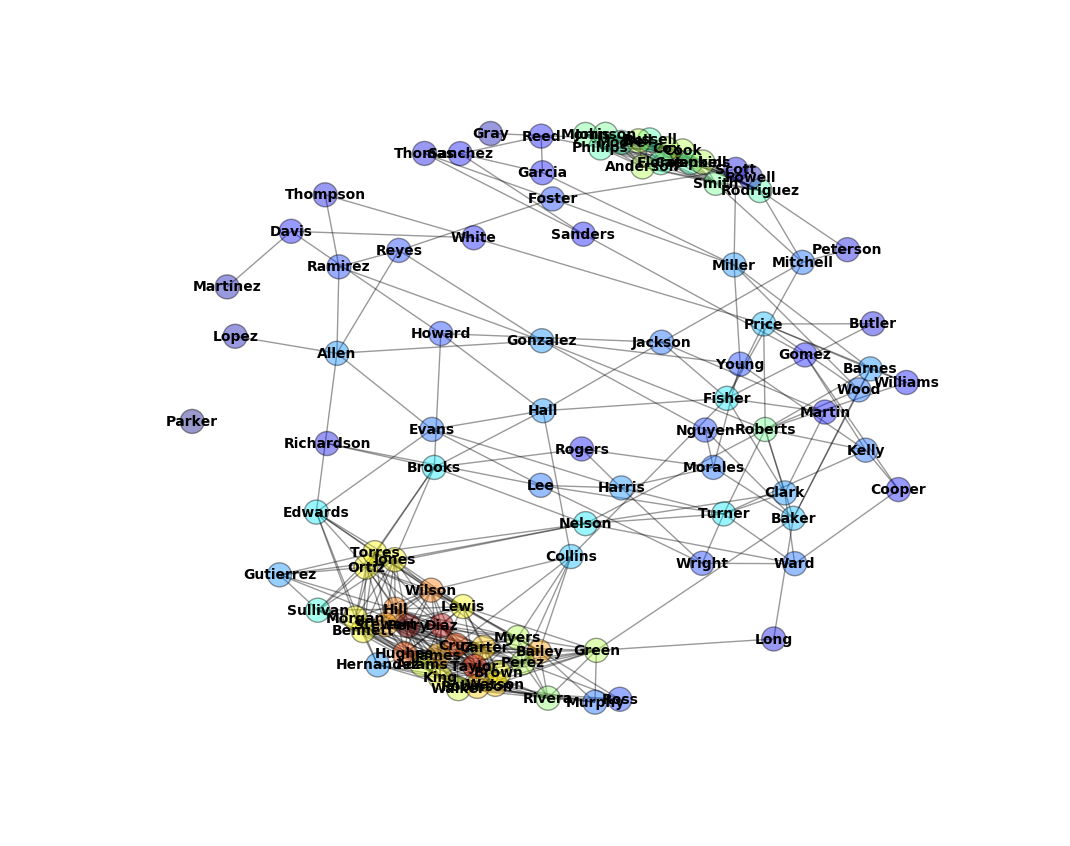

In [174]:
plt.figure(figsize=(10,8))
node_color=[float(G.degree(n)) for n in G]
nx.draw(G,with_labels=True,node_color=node_color,font_weight='bold',
        font_size=10,font_color='k',alpha=0.4)